In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files
from zipfile import ZipFile
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
uploaded = files.upload()

Saving data.zip to data.zip


In [3]:
from zipfile import ZipFile
dataset = '/content/data.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [4]:
base_dir = '/content/data'
with_mask_files = os.listdir('/content/data/with_mask')
print(with_mask_files[0:5])
print(with_mask_files[-5:])
without_mask_files = os.listdir('/content/data/without_mask')
print(without_mask_files[0:5])
print(without_mask_files[-5:])

['with_mask_1327.jpg', 'with_mask_2523.jpg', 'with_mask_1419.jpg', 'with_mask_88.jpg', 'with_mask_3443.jpg']
['with_mask_1631.jpg', 'with_mask_2292.jpg', 'with_mask_3250.jpg', 'with_mask_2829.jpg', 'with_mask_3320.jpg']
['without_mask_3493.jpg', 'without_mask_2638.jpg', 'without_mask_873.jpg', 'without_mask_39.jpg', 'without_mask_1935.jpg']
['without_mask_1159.jpg', 'without_mask_1933.jpg', 'without_mask_3356.jpg', 'without_mask_3660.jpg', 'without_mask_3437.jpg']


In [6]:
print("Number of with mask images:", len(with_mask_files))
print("Number of without mask images:", len(without_mask_files))

Number of with mask images: 3725
Number of without mask images: 3828


In [7]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 30

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    shear_range=0.15,
    fill_mode='nearest',
    validation_split=0.2
)

In [9]:
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [10]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

Found 6043 images belonging to 2 classes.


In [11]:
validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

print(f"Class indices: {train_generator.class_indices}")

Found 1510 images belonging to 2 classes.
Class indices: {'with_mask': 0, 'without_mask': 1}


**MODEL ARCHITECTURE - Transfer Learning with MobileNetV2**

In [12]:
def create_improved_model():

    # Loading pre-trained MobileNetV2 model

    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )


    base_model.trainable = False

    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    return model, base_model

**Creating model**

In [13]:
model, base_model = create_improved_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Compiling the model**

In [14]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,431,041 (9.27 MB)

 Trainable params: 172,673 (674.50 KB)

 Non-trainable params: 2,258,368 (8.61 MB)

In [15]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [16]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

In [17]:
checkpoint = ModelCheckpoint(
    'best_mask_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

**Training the model (Phase - 1 : Training only top layers)**

In [18]:
print("Phase 1: Training top layers only...")
history_phase1 = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Phase 1: Training top layers only...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 75/189 ━━━━━━━━━━━━━━━━━━━━ 43s 383ms/step - accuracy: 0.8740 - loss: 0.2816 - precision: 0.8631 - recall: 0.8895

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9155 - loss: 0.1984 - precision: 0.9078 - recall: 0.9260
Epoch 1: val_accuracy improved from -inf to 0.98411, saving model to best_mask_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 123s 544ms/step - accuracy: 0.9157 - loss: 0.1980 - precision: 0.9080 - recall: 0.9261 - val_accuracy: 0.9841 - val_loss: 0.0446 - val_precision: 0.9818 - val_recall: 0.9869 - learning_rate: 0.0010
Epoch 2/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9816 - loss: 0.0589 - precision: 0.9835 - recall: 0.9803
Epoch 2: val_accuracy did not improve from 0.98411
189/189 ━━━━━━━━━━━━━━━━━━━━ 77s 409ms/step - accuracy: 0.9816 - loss: 0.0589 - precision: 0.9834 - recall: 0.9803 - val_accuracy: 0.9834 - val_loss: 0.0478 - val_precision: 0.9756 - val_recall: 0.9922 - learning_rate: 0.0010
Epoch 3/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9768 - loss: 0.0708 - precision: 0.9796 - recall: 0.9742
Epoch 3: val_accuracy did not improve from 0.98411
189/189 ━━━━━━━━━━━━━━━━━━━━ 76s 403ms/step - accuracy: 0.9768 - loss: 0.0708 - precision: 0.9796 - recall: 0.9743 - val_accuracy: 0.9834 - val_loss: 0.0504 - val_precision: 0.9843 - val_recall: 0.

189/189 ━━━━━━━━━━━━━━━━━━━━ 77s 407ms/step - accuracy: 0.9812 - loss: 0.0539 - precision: 0.9823 - recall: 0.9805 - val_accuracy: 0.9868 - val_loss: 0.0362 - val_precision: 0.9921 - val_recall: 0.9817 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 5.


**Training the model (Phase - 2 : Fine Tuning)**

In [19]:
print("\nPhase 2: Fine-tuning...")
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=0.0001/10),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


Phase 2: Fine-tuning...


**Continue Training**

In [20]:
history_phase2 = model.fit(
    train_generator,
    epochs=10,
    initial_epoch=history_phase1.epoch[-1],
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9281 - loss: 0.1989 - precision_1: 0.9441 - recall_1: 0.9136
Epoch 5: val_accuracy improved from 0.98675 to 0.99007, saving model to best_mask_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 124s 526ms/step - accuracy: 0.9281 - loss: 0.1986 - precision_1: 0.9441 - recall_1: 0.9137 - val_accuracy: 0.9901 - val_loss: 0.0335 - val_precision_1: 0.9845 - val_recall_1: 0.9961 - learning_rate: 1.0000e-05
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9640 - loss: 0.0990 - precision_1: 0.9710 - recall_1: 0.9575
Epoch 6: val_accuracy improved from 0.99007 to 0.99205, saving model to best_mask_model.h5


189/189 ━━━━━━━━━━━━━━━━━━━━ 78s 413ms/step - accuracy: 0.9640 - loss: 0.0990 - precision_1: 0.9710 - recall_1: 0.9575 - val_accuracy: 0.9921 - val_loss: 0.0281 - val_precision_1: 0.9896 - val_recall_1: 0.9948 - learning_rate: 1.0000e-05
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9718 - loss: 0.0790 - precision_1: 0.9759 - recall_1: 0.9685
Epoch 7: val_accuracy did not improve from 0.99205
189/189 ━━━━━━━━━━━━━━━━━━━━ 78s 414ms/step - accuracy: 0.9718 - loss: 0.0790 - precision_1: 0.9759 - recall_1: 0.9685 - val_accuracy: 0.9907 - val_loss: 0.0265 - val_precision_1: 0.9896 - val_recall_1: 0.9922 - learning_rate: 1.0000e-05
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9777 - loss: 0.0591 - precision_1: 0.9799 - recall_1: 0.9761
Epoch 8: val_accuracy did not improve from 0.99205
189/189 ━━━━━━━━━━━━━━━━━━━━ 78s 412ms/step - accuracy: 0.9777 - loss: 0.0591 - precision_1: 0.9800 - recall_1: 0.9761 - val_accuracy: 0.9901 - val_loss: 0.0264 - v

**Visualization**

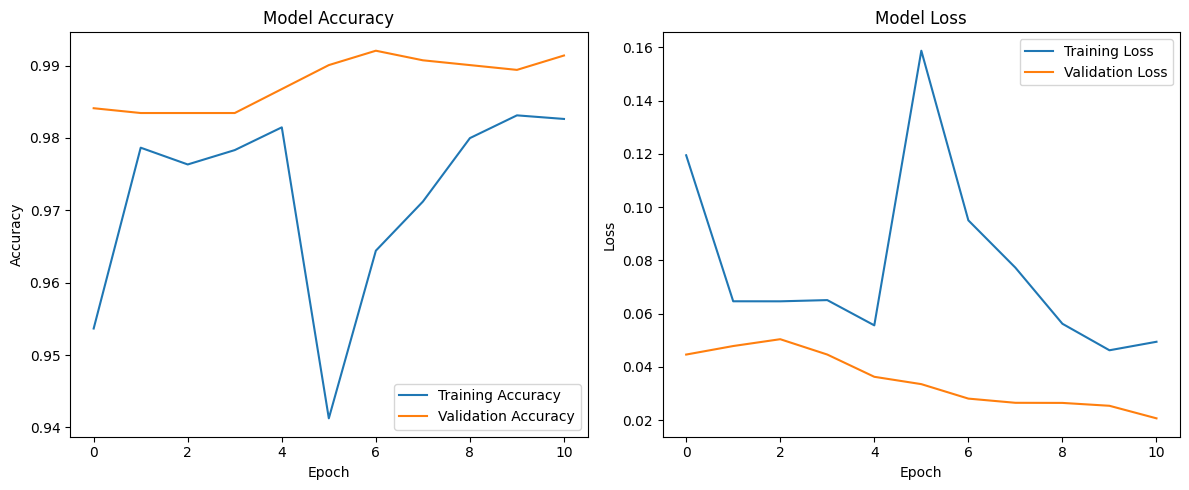

In [21]:
def plot_training_history(history1, history2=None):
    """Plot training and validation metrics"""

    if history2:

        acc = history1.history['accuracy'] + history2.history['accuracy']
        val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
        loss = history1.history['loss'] + history2.history['loss']
        val_loss = history1.history['val_loss'] + history2.history['val_loss']
    else:
        acc = history1.history['accuracy']
        val_acc = history1.history['val_accuracy']
        loss = history1.history['loss']
        val_loss = history1.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))


    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')


    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history_phase1, history_phase2)

**Evaluation**

In [22]:
test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


# Evaluate model:

evaluation = model.evaluate(validation_generator)
print(f"\nValidation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]:.4f}")
print(f"Validation Precision: {evaluation[2]:.4f}")
print(f"Validation Recall: {evaluation[3]:.4f}")

Found 7553 images belonging to 2 classes.
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9924 - loss: 0.0184 - precision_1: 0.5224 - recall_1: 0.5218

Validation Loss: 0.0206
Validation Accuracy: 0.9914
Validation Precision: 0.9960
Validation Recall: 0.9869


**Prediction System**

In [23]:
def predict_mask(model, image_path):

    "Predict whether a person is wearing a mask or not"
    try:


        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image from {image_path}")
            return None

        cv2_imshow(img)



        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (IMG_HEIGHT, IMG_WIDTH))
        img_scaled = img_resized / 255.0
        img_reshaped = np.expand_dims(img_scaled, axis=0)


        prediction = model.predict(img_reshaped, verbose=0)[0][0]


        confidence = prediction if prediction > 0.5 else 1 - prediction

        if prediction > 0.5:
            result = "WITHOUT MASK"
            color = (0, 0, 255)
        else:
            result = "WITH MASK"
            color = (0, 255, 0)

        print(f"\nPrediction: {result}")
        print(f"Confidence: {confidence:.2%}")


        # Adding text to image:

        img_with_text = img.copy()
        cv2.putText(img_with_text, f"{result} ({confidence:.1%})",
                   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
        cv2_imshow(img_with_text)

        return prediction

    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None

**Test Prediction System**

In [24]:
print("PREDICTION SYSTEM RESULT :")

image_path = input("Enter the path of the image to be predicted: ")
prediction = predict_mask(model, image_path)


#For multiple images

def predict_batch(model, image_paths):
    "Prediction System Result :"
    predictions = []
    for path in image_paths:
        print(f"\nProcessing: {path}")
        pred = predict_mask(model, path)
        if pred is not None:
            predictions.append(pred)
    return predictions

PREDICTION SYSTEM RESULT :
Enter the path of the image to be predicted: 
Error: Could not read image from 


**Save the model**

In [25]:
model.save('best_mask_model.h5')
model.save('best_mask_model.keras')
print("\nModel saved successfully!")


Model saved successfully!


In [26]:
from google.colab import drive
drive.mount('/content/drive')

# Save in Drive
model.save("/content/drive/MyDrive/best_mask_model.h5")


Mounted at /content/drive
